In [1]:
import pandas as pd
import matplotlib.pyplot as plt

DataGeneration loads the data from:

https://data.open-power-system-data.org/time_series/ 

From this website the years 2015-2020 (2020 only includes data points from 1st of January - 30th of September) are downloaded.
For each hour in a given year the load demand, solar profile, wind profile on and offshore are downloaded for Denmark (DK1 and DK2), Germany and Norway

# Der er ikke noget data for wind_profile og solar_profile for DK og NO, så jeg har taget det fra capacity, og divideret med maks kapaciteten

In [2]:
from CostGeneration import CostGeneration
from DataGeneration import DataGeneration


In [117]:
tmp_1 = CostGeneration()

tmp_1.costs.at['offwind', "marginal_cost"] 




0.0212

In [5]:
import pypsa
import pandas as pd
from CostGeneration import CostGeneration
from DataGeneration import DataGeneration


technology_data = {'gas': {'Marginal_cost': 21.6, 'Efficiency': 0.39, 'Capital_cost': 560000, 'Lifetime': 25, 'CO2_emissions': 0.19},
                   'onshorewind': {'Marginal_cost': 21.6, 'Efficiency': 0.39, 'Capital_cost': 560000, 'Lifetime': 25, 'CO2_emissions': 0.19},
                   'Solar': {'Marginal_cost': 21.6, 'Efficiency': 0.39, 'Capital_cost': 560000, 'Lifetime': 25, 'CO2_emissions': 0.19},
             }

class BuildBaseNetwork:
    def __init__(self, year: int = 2019, cost_year: int = 2020,
                 technology_data = dict, interest_rate = 0.07, 
                #  carriers: list[str] = ["onwind", "solar", "OCGT", "CCGT", "battery storage"], 
                #  multiple_regions = False,
                 setup: dict = {'DK': 
                            {'OCGT': True,
                            'CCGT': True,
                            'battery storage': True,
                            'onshore wind': True,
                            'solar': True}}):
        
        self.year = year
        self.cost_year = cost_year 

        self.costs = CostGeneration(year = self.cost_year).costs

        self.interest_rate = interest_rate

        self.setup = setup
        self.regions = setup.keys()
        
        self.network = pypsa.Network()
        self.hours_in_year = pd.date_range(f'{year}-01-01 00:00', f'{year}-12-31 23:00', freq='h')
        self.network.set_snapshots(self.hours_in_year.values)

        self.data_dict = {region : {} for region in self.regions}

        self.carriers = ['gas', 'onwind', 'offwind', 'solar']

        self.network.add("Carrier", self.carriers, color=["dodgerblue", "gold", "indianred", "yellow-green"], co2_emissions=[self.costs.at[c, "CO2 intensity"] for c in self.carriers])

        for region in self.regions:
            data = DataGeneration(year = self.year, region = region)
            self.data_dict[region]['Demand'] = data.demand
            self.data_dict[region]['solar'] = data.solar
            self.data_dict[region]['onwind'] = data.onshore_wind
            self.data_dict[region]['offwind'] = data.offshore_wind
        
            self.add_busses(region)
            technologies = self.setup[region].keys()
            for tech in technologies:
                if tech in ['OCGT', 'CCGT']:
                    self.network.add("Generator", f'{tech} {region}', 
                                     bus = f'electricity bus {region}', 
                                     p_nom_extendable=True, 
                                     carrier='gas', 
                                     capital_cost = self.costs.at[tech, "capital_cost"], 
                                     marginal_cost = self.costs.at[tech, "marginal_cost"])
                elif tech == 'solar':
                    self.network.add("Generator", f'{tech} {region}', 
                                     bus = f'electricity bus {region}', 
                                     p_nom_extendable=True, 
                                     carrier='solar', 
                                     capital_cost = self.costs.at[tech, "capital_cost"], 
                                     marginal_cost = self.costs.at[tech, "marginal_cost"],
                                     p_max_pu = self.data_dict[region]['solar'].values.flatten())     
                elif tech == 'onwind':
                    self.network.add("Generator", f'{tech} {region}', 
                                     bus = f'electricity bus {region}', 
                                     p_nom_extendable=True, 
                                     carrier='onwind', 
                                     capital_cost = self.costs.at[tech, "capital_cost"], 
                                     marginal_cost = self.costs.at[tech, "marginal_cost"],
                                     p_max_pu = self.data_dict[region]['onwind'].values.flatten())  
                elif tech == 'offwind':
                    self.network.add("Generator", f'{tech} {region}', 
                                     bus = f'electricity bus {region}', 
                                     p_nom_extendable=True, 
                                     carrier='offwind', 
                                     capital_cost = self.costs.at[tech, "capital_cost"], 
                                     marginal_cost = self.costs.at[tech, "marginal_cost"],
                                     p_max_pu = self.data_dict[region]['offwind'].values.flatten())

        self.network.optimize(solver_name='gurobi')

    def add_busses(self, region):
        self.network.add("Bus", f'electricity bus {region}')
        self.network.add("Load", f'load {region}', bus = f'electricity bus {region}', p_set = self.data_dict[region]['Demand'].values.flatten())


    #     # add the different carriers, only gas emits CO2

    #     self.network.add("Carrier", self.carriers, color=["dodgerblue", "gold", "indianred","yellow-green", "brown"], co2_emissions=[self.costs.at[c, "CO2 intensity"] for c in self.carriers])

    #     # self.network.add("Carrier", "gas", co2_emissions=0.19) # in t_CO2/MWh_th
    #     self.network.add("Carrier", "gas", co2_emissions = self.technology_data['gas']['CO2_emissions'])
    #     # add OCGT (Open Cycle Gas Turbine) generator
    #     capital_cost_OCGT = self.annuity(25, self.interest_rate)*560000*(1+0.033) # in €/MW
    #     fuel_cost = 21.6 # in €/MWh_th
    #     efficiency = 0.39 # MWh_elec/MWh_th
    #     marginal_cost_OCGT = fuel_cost/efficiency # in €/MWh_el
        
    #     self.network.add("Generator",
    #                 "OCGT",
    #                 bus="electricity bus",
    #                 p_nom_extendable=True,
    #                 carrier="gas",
    #                 #p_nom_max=1000,
    #                 capital_cost = capital_cost_OCGT,
    #                 marginal_cost = marginal_cost_OCGT)

    #     self.network.add("Carrier", "onshorewind")
    #     # add onshore wind generator
    #     CF_wind = self.profile_data['DK_wind_onshore_generation_actual'].values
    #     capital_cost_onshorewind = self.annuity(30, self.interest_rate) * self.technology_data['onshorewind']['Capital_cost'] * (1+0.033) # in €/MW
    #     self.network.add("Generator",
    #                 "onshorewind",
    #                 bus="electricity bus",
    #                 p_nom_extendable=True,
    #                 carrier="onshorewind",
    #                 #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
    #                 capital_cost = capital_cost_onshorewind,
    #                 marginal_cost = 0,
    #                 p_max_pu = CF_wind)

    #     self.network.add("Carrier", "solar")

    #     # add solar PV generator
    #     CF_solar = self.profile_data['DK_solar_generation_actual'].values
    #     capital_cost_solar = self.annuity(25,0.07)*425000*(1+0.03) # in €/MW
    #     self.network.add("Generator",
    #                 "solar",
    #                 bus="electricity bus",
    #                 p_nom_extendable=True,
    #                 carrier="solar",
    #                 #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
    #                 capital_cost = capital_cost_solar,
    #                 marginal_cost = 0,
    #                 p_max_pu = CF_solar)

    # def add_line(self, name, bus0, bus1, length, s_nom):
    #     self.network.add("Line", name, bus0, bus1, length=length, s_nom=s_nom)

    @staticmethod
    def annuity(n, r):
        """ Calculate the annuity factor for an asset with lifetime n years and
        discount rate  r """

        if r > 0:
            return r/(1. - 1./(1.+r)**n)
        else:
            return 1/n


In [106]:
print(tmp.costs.at['solar', "capital_cost"])
print(tmp.costs.at['solar', "marginal_cost"])

print(tmp.costs.at['OCGT', "capital_cost"])
print(tmp.costs.at['OCGT', "marginal_cost"])


75323.80208848667
0.0106
49760.036522390714
66.182


In [9]:
setup = {'DK': 
                            {'OCGT': True,
                            'solar': True,
                            'onwind': True},
        # 'DE':  {'OCGT': True,
        #         'solar': True} 
                }

tmp = BuildBaseNetwork(setup = setup)


Year 2019 is greater than 2017, using data from last available year.


Index(['electricity bus DK'], dtype='object', name='Bus')
Index(['electricity bus DK'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 37.05it/s]
INFO:linopy.io: Writing time: 0.38s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2617852


INFO:gurobipy:Set parameter LicenseID to value 2617852


Academic license - for non-commercial use only - expires 2026-02-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-04


Read LP format model from file C:\Users\Jeppe Urup Byberg\AppData\Local\Temp\linopy-problem-621egg13.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeppe Urup Byberg\AppData\Local\Temp\linopy-problem-621egg13.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 61323 rows, 26283 columns, 100760 nonzeros


INFO:gurobipy:obj: 61323 rows, 26283 columns, 100760 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 61323 rows, 26283 columns and 100760 nonzeros


INFO:gurobipy:Optimize a model with 61323 rows, 26283 columns and 100760 nonzeros


Model fingerprint: 0xc51209fa


INFO:gurobipy:Model fingerprint: 0xc51209fa


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e-02, 1e+05]


INFO:gurobipy:  Objective range  [1e-02, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 7e+03]


INFO:gurobipy:  RHS range        [2e+03, 7e+03]


Presolve removed 35009 rows and 8726 columns


INFO:gurobipy:Presolve removed 35009 rows and 8726 columns


Presolve time: 0.10s


INFO:gurobipy:Presolve time: 0.10s


Presolved: 26314 rows, 17557 columns, 57025 nonzeros


INFO:gurobipy:Presolved: 26314 rows, 17557 columns, 57025 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 3


INFO:gurobipy: Dense cols : 3


 AA' NZ     : 3.947e+04


INFO:gurobipy: AA' NZ     : 3.947e+04


 Factor NZ  : 1.273e+05 (roughly 20 MB of memory)


INFO:gurobipy: Factor NZ  : 1.273e+05 (roughly 20 MB of memory)


 Factor Ops : 6.631e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.631e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.83705704e+10 -1.62283882e+11  7.03e+04 0.00e+00  1.14e+08     0s


INFO:gurobipy:   0   2.83705704e+10 -1.62283882e+11  7.03e+04 0.00e+00  1.14e+08     0s


   1   4.93370527e+10 -1.98216909e+11  7.85e+03 5.51e+02  1.95e+07     0s


INFO:gurobipy:   1   4.93370527e+10 -1.98216909e+11  7.85e+03 5.51e+02  1.95e+07     0s


   2   4.00748604e+10 -6.61390025e+10  1.09e-11 1.19e+00  1.90e+06     0s


INFO:gurobipy:   2   4.00748604e+10 -6.61390025e+10  1.09e-11 1.19e+00  1.90e+06     0s


   3   7.98940414e+09 -5.87415799e+09  7.28e-12 8.24e-10  2.44e+05     0s


INFO:gurobipy:   3   7.98940414e+09 -5.87415799e+09  7.28e-12 8.24e-10  2.44e+05     0s


   4   4.46566673e+09 -4.25049575e+08  5.46e-12 6.44e-10  8.59e+04     0s


INFO:gurobipy:   4   4.46566673e+09 -4.25049575e+08  5.46e-12 6.44e-10  8.59e+04     0s


   5   3.58098216e+09  4.34966134e+08  1.09e-11 3.42e-10  5.52e+04     1s


INFO:gurobipy:   5   3.58098216e+09  4.34966134e+08  1.09e-11 3.42e-10  5.52e+04     1s


   6   3.48628470e+09  8.17068015e+08  3.27e-11 1.26e-09  4.69e+04     1s


INFO:gurobipy:   6   3.48628470e+09  8.17068015e+08  3.27e-11 1.26e-09  4.69e+04     1s


   7   2.97768323e+09  1.44513510e+09  3.60e-10 1.88e-10  2.69e+04     1s


INFO:gurobipy:   7   2.97768323e+09  1.44513510e+09  3.60e-10 1.88e-10  2.69e+04     1s


   8   2.64313314e+09  1.73354379e+09  1.13e-10 3.55e-10  1.60e+04     1s


INFO:gurobipy:   8   2.64313314e+09  1.73354379e+09  1.13e-10 3.55e-10  1.60e+04     1s


   9   2.48859309e+09  2.04762218e+09  2.84e-10 2.69e-10  7.74e+03     1s


INFO:gurobipy:   9   2.48859309e+09  2.04762218e+09  2.84e-10 2.69e-10  7.74e+03     1s


  10   2.38366330e+09  2.20595357e+09  7.28e-11 2.08e-10  3.12e+03     1s


INFO:gurobipy:  10   2.38366330e+09  2.20595357e+09  7.28e-11 2.08e-10  3.12e+03     1s


  11   2.34147123e+09  2.25528477e+09  1.90e-09 6.08e-10  1.51e+03     1s


INFO:gurobipy:  11   2.34147123e+09  2.25528477e+09  1.90e-09 6.08e-10  1.51e+03     1s


  12   2.31778945e+09  2.26093820e+09  1.83e-09 1.37e-09  9.97e+02     1s


INFO:gurobipy:  12   2.31778945e+09  2.26093820e+09  1.83e-09 1.37e-09  9.97e+02     1s


  13   2.30352698e+09  2.26703454e+09  5.62e-10 2.20e-12  6.40e+02     1s


INFO:gurobipy:  13   2.30352698e+09  2.26703454e+09  5.62e-10 2.20e-12  6.40e+02     1s


  14   2.29398002e+09  2.27226445e+09  1.29e-09 5.27e-10  3.81e+02     1s


INFO:gurobipy:  14   2.29398002e+09  2.27226445e+09  1.29e-09 5.27e-10  3.81e+02     1s


  15   2.28842210e+09  2.27763102e+09  2.20e-09 9.93e-10  1.89e+02     1s


INFO:gurobipy:  15   2.28842210e+09  2.27763102e+09  2.20e-09 9.93e-10  1.89e+02     1s


  16   2.28520273e+09  2.27884165e+09  5.12e-09 1.02e-09  1.12e+02     1s


INFO:gurobipy:  16   2.28520273e+09  2.27884165e+09  5.12e-09 1.02e-09  1.12e+02     1s


  17   2.28326770e+09  2.27982729e+09  2.73e-09 9.92e-10  6.04e+01     1s


INFO:gurobipy:  17   2.28326770e+09  2.27982729e+09  2.73e-09 9.92e-10  6.04e+01     1s


  18   2.28283679e+09  2.28013996e+09  2.10e-09 8.42e-10  4.73e+01     1s


INFO:gurobipy:  18   2.28283679e+09  2.28013996e+09  2.10e-09 8.42e-10  4.73e+01     1s


  19   2.28172264e+09  2.28082964e+09  3.10e-09 1.60e-10  1.57e+01     1s


INFO:gurobipy:  19   2.28172264e+09  2.28082964e+09  3.10e-09 1.60e-10  1.57e+01     1s


  20   2.28134394e+09  2.28111884e+09  2.67e-09 6.53e-10  3.95e+00     1s


INFO:gurobipy:  20   2.28134394e+09  2.28111884e+09  2.67e-09 6.53e-10  3.95e+00     1s


  21   2.28128232e+09  2.28125676e+09  2.01e-09 7.56e-10  4.48e-01     1s


INFO:gurobipy:  21   2.28128232e+09  2.28125676e+09  2.01e-09 7.56e-10  4.48e-01     1s


  22   2.28126644e+09  2.28126636e+09  1.56e-08 1.42e-10  1.39e-03     1s


INFO:gurobipy:  22   2.28126644e+09  2.28126636e+09  1.56e-08 1.42e-10  1.39e-03     1s


  23   2.28126640e+09  2.28126640e+09  6.85e-09 1.38e-10  1.39e-06     1s


INFO:gurobipy:  23   2.28126640e+09  2.28126640e+09  6.85e-09 1.38e-10  1.39e-06     1s


  24   2.28126640e+09  2.28126640e+09  1.36e-10 1.31e-09  1.39e-12     1s


INFO:gurobipy:  24   2.28126640e+09  2.28126640e+09  1.36e-10 1.31e-09  1.39e-12     1s


INFO:gurobipy:


Barrier solved model in 24 iterations and 1.30 seconds (0.25 work units)


INFO:gurobipy:Barrier solved model in 24 iterations and 1.30 seconds (0.25 work units)


Optimal objective 2.28126640e+09


INFO:gurobipy:Optimal objective 2.28126640e+09


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4402 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:    4402 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


       1 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       1 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0569039e-09      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0569039e-09      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    4406    2.2812664e+09   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:    4406    2.2812664e+09   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 4406 iterations and 1.51 seconds (0.28 work units)


INFO:gurobipy:Solved in 4406 iterations and 1.51 seconds (0.28 work units)


Optimal objective  2.281266403e+09


INFO:gurobipy:Optimal objective  2.281266403e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 26283 primals, 61323 duals
Objective: 2.28e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


In [10]:
# tmp.network.loads_t.p_set
# tmp.network.generators_t.p_max_pu
tmp.network.generators.p_nom_opt

Generator
OCGT DK      5310.884881
solar DK        0.000000
onwind DK    6504.323570
Name: p_nom_opt, dtype: float64

In [2]:
from DataGeneration import DataGeneration

# Get the data for a certain year 
year = 2019
region = 'DK'

DK1_data = DataGeneration(year = year, region = region)

DK1_data.demand

Year 2019 is greater than 2017, using data from last available year.


,DK_demand
utc_timestamp,
2019-01-01 00:00:00+00:00,3186.04
2019-01-01 01:00:00+00:00,3070.07
2019-01-01 02:00:00+00:00,2966.19
2019-01-01 03:00:00+00:00,2933.48
2019-01-01 04:00:00+00:00,2940.64
...,...
2019-12-31 19:00:00+00:00,3785.27
2019-12-31 20:00:00+00:00,3582.21
2019-12-31 21:00:00+00:00,3438.26


In [ ]:
tmp = {'DK_1': 
            {'OCGT': True,
            'CCGT': True,
            'battery storage': True,
            'onshore wind': True,
            'solar': True},
        'DE': {'OCGT': True,
            'CCGT': True,
            'battery storage': True,
            'onshore wind': True,
            'solar': True}}

tmp['DE']



# Task A

In [37]:
setup = {'DK_1': 
                            {'OCGT': True,
                            'CCGT': True,
                            'battery storage': True,
                            'onshore wind': True,
                            'solar': True},
        'DE':  {'OCGT': True,
                'CCGT': True,
                'battery storage': True,
                'onshore wind': True,
                'solar': True} }

In [24]:
import numpy as np
tmp.data_dict['DK']['Demand'].values.flatten()

array([3186.04, 3070.07, 2966.19, ..., 3438.26, 3309.25, 3315.91])

In [7]:
technology_data['onshorewind']['Capital_cost']



560000

Det er noteret at:

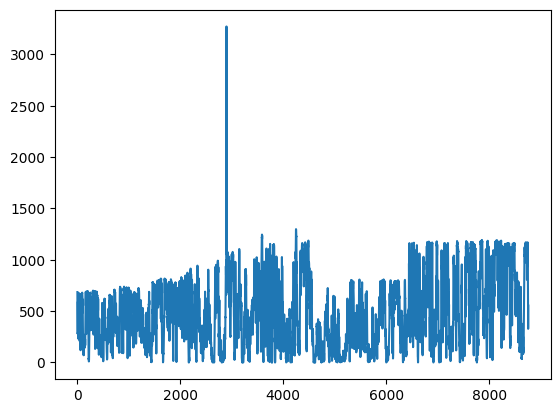

In [19]:
plt.plot(DataGeneration(year = 2019, region = 'DK_1').data['wind_offshore_generation_actual'].values)
plt.show()


Year 2018 is greater than 2017, using data from last available year.
Year 2019 is greater than 2017, using data from last available year.
Year 2020 is greater than 2017, using data from last available year.


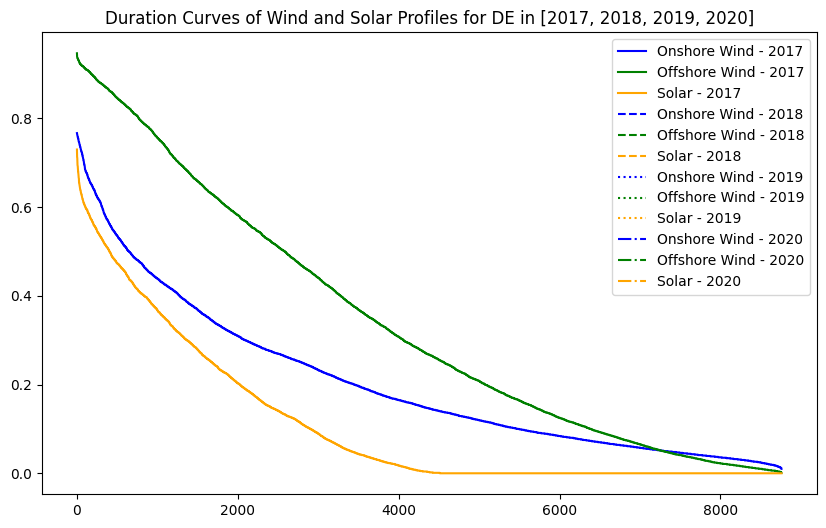

NameError: name 'plt' is not defined

In [2]:
from DurationCurve import DurationCurve

# region = 'DK_1'
# region = 'DK_2'
# region = 'NO'
region = 'DE'

years = [2017, 2018, 2019, 2020]

DurationCurve(years = years, region = region)
plt.show()